## Information Mining for COVID-19 Research From a Large Volume of Scientific Literature

<center>Sabber Ahamed (sabbers@gmail.com), Manar Samad (msamad@tnstate.edu)</center>
<br>

In this project, we developed a graph-based model using abstracts of 10,683 scientific articles to find key information on three topics: transmission, drug types, and genome research related to coronavirus. A subgraph is built for each of the three topics to extract topic-focused information. Within each subgraph, we use a betweenness centrality to rank the importance of keywords. The results reveal intriguing information about antiviral drugs (Chloroquine, Amantadine, Dexamethasone), pathogen-hosts (pigs, bats, macaque, cynomolgus), viral pathogens (zika, dengue, malaria, and several viruses in the coronaviridae virus family), and proteins and therapeutic mechanisms (oligonucleotide, interferon, glycoprotein) in connection with the core topic of coronavirus. The categorical summary of these keywords and topics may be a useful reference to expedite and recommend new and alternative directions for COVID-19 research.

### Graph
The project repository (https://github.com/msahamed/covid19-text-network) contains all the graph files (.gephi and .gexf). 
You need to install Gephi to visualize the network.

<li> covid19_abstract.geph is the graph network of all the available abstracts. <\li>
<li>covid19_abstract.gexf is the graph meta data of all the abstracts.<\li>
<li> covid19_title.geph is the graph network of all the titles of 29K articles.<\li>
<li> covid19_title.gexf is the graph meta data of all the titles of 29K articles.<\li>

### Paper:
The manuscript associated with work can be found on here: https://arxiv.org/abs/2004.02085.

### Import all the necessary library

In [49]:
import warnings
def warn(*arg, **kwarg):
    pass
warnings.warn = warn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json
from IPython.display import Image

In [50]:
import py2neo
from py2neo import Graph
import jgraph as IGraph
from IPython.display import Image
from IPython.core.display import HTML 

import numpy as np
import pandas as pd

# Other
import re
import string

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

## Plot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt

## <b> Data Processing<b>

In [51]:
root_path = './CORD-19-research-challenge'
metadata_path = f'{root_path}/all_sources_metadata_2020-03-13.csv'

In [52]:
metadata_path

'./CORD-19-research-challenge/all_sources_metadata_2020-03-13.csv'

In [53]:
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head(3)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2002765492,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3003430844,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3006065484,#1043,True


In [54]:
meta_df.shape

(29500, 14)

In [55]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

13202

### Reading raw json files

In [56]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            self.title = content['metadata']['title']
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

    def __repr__(self):
        return f'{self.paper_id}: {self.title}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

8f8eb4f004c2002face0723f2f58cc411954d36e: Complete Genome Sequence of Bordetella bronchiseptica Strain KM22: Bordetella bronchiseptica isolate KM22 has been used in experimental infections of swine as a model of clinical B. bronchiseptica infection and to study host-to-host transmission. The draft genome seq... 20-kb insert library preparation protocol (https://www.pacb.com/wp-content/uploads/ Procedure-Checklist-20-kb-Template-Preparation-Using-BluePippin-Size-Selection -System.pdf). The 20-kb library was s...


In [57]:
dict_ = {'paper_id': [], 'title': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['title'].append(content.title)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'title', 'abstract', 'body_text'])

Processing index: 0 of 13202
Processing index: 1320 of 13202
Processing index: 2640 of 13202
Processing index: 3960 of 13202
Processing index: 5280 of 13202
Processing index: 6600 of 13202
Processing index: 7920 of 13202
Processing index: 9240 of 13202
Processing index: 10560 of 13202
Processing index: 11880 of 13202
Processing index: 13200 of 13202


In [58]:
df_covid.head()
df_covid.shape

(13202, 4)

### Remove the duplicates

In [59]:
df_covid.drop_duplicates(['title'], inplace=True)
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.drop_duplicates(['body_text'], inplace=True)

In [60]:
print(f'Title: {df_covid["title"].nunique()}, Abstract: {df_covid["abstract"].nunique()}, Body: {df_covid["body_text"].nunique()}')

Title: 10683, Abstract: 10683, Body: 10683


In [61]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['title'] = df_covid['title'].apply(lambda x: lower_case(x))
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

### Update stopwords

In [62]:
def regexReplcae(text):
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"(\"?\')(\w)", " \2", text)
    text = re.sub(r"\?", " .", text)
    text = re.sub(r",", "", text)
    text = re.sub(r"\.\s?", " SEP.SEP ", text)
    text = re.sub(r"!", ".", text)
    text = re.sub(r":", "", text)
    text = re.sub(r"\s?\;\s?", "", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\(", "", text)
    text = re.sub(r"\)", "", text)
    text = re.sub(r"&", " ", text)
    text = re.sub(r"([A-z])\-([A-z])", r"\1 \2", text)
    text = re.sub(r"viruses", "virus", text)
    text = re.sub(r"proteins", "protein", text)
    text = re.sub(r"genes", "gene", text)
    text = re.sub(r"pathogens", "pathogen", text)
    text = re.sub(r"cells", "cell", text)
    text = re.sub(r"drugs", "drug", text)
    text = re.sub(r"vaccines", "vaccine", text)
    text = re.sub(r"vaccination", "vaccine", text)
    text = re.sub(r"genomes", "gene", text)
    text = re.sub(r"genotypes", "genotype", text)
    text = re.sub(r"diseases", "disease", text)
    text = re.sub(r"pathogenesis", "pathogen", text)
    text = re.sub(r"pathogeneis", "pathogen", text)
    text = re.sub(r"pathogenic", "pathogen", text)
    text = re.sub(r"infections", "infection", text)
    text = re.sub(r"infected", "infection", text)
    text = re.sub(r"antibodies", "antibody", text)
    text = re.sub(r"zikv", "zikavirus", text)
    text = re.sub(r"zika", "zikavirus", text)
    text = re.sub(r"bats", "bat", text)
    text = re.sub(r"dogs", "dog", text)
    text = re.sub(r"cats", "cat", text)
    text = re.sub(r"sequences", "sequence", text)
    text = re.sub(r"experiments", "experiment", text)
    text = re.sub(r"sequencing", "sequence", text)
    text = re.sub(r"author\s?", "", text)
    text = re.sub(r"corresponding\s?", "", text)
    text = re.sub(r"inhibited", "inhibit", text)
    text = re.sub(r"inhibitor", "inhibit", text)
    text = re.sub(r"adults", "adult", text)   
    text = re.sub(r"interactions", "interaction", text)
    text = re.sub(r"[^\s@]+@[^\s@]+\.[^\s@]{2,}", " ", text)
    return text

In [63]:
all_text = ' '.join(df_covid['abstract'])
all_text = regexReplcae(all_text)

In [64]:
allWords = nltk.tokenize.word_tokenize(all_text)
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

In [65]:
freq_df = pd.DataFrame(allWordDist.items()).rename(columns = {0:'word', 1: 'count'})
freq_df.sort_values(by = ['count'], ascending = False, inplace= True)

In [66]:
freq_df[freq_df['count'] <= 1].count()

word     37844
count    37844
dtype: int64

In [67]:
freq_df.shape

(76289, 2)

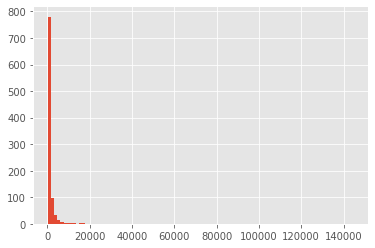

In [68]:
import matplotlib.pyplot as plt
plt.hist(freq_df[freq_df['count'] >400]['count'], bins = 100, density=False);

In [72]:
print(f'Stop words from histogram: {len(list(freq_df[freq_df["count"]  >= 400]["word"]))}')

Stop words from histogram: 971


In [73]:
from stopwords_list import stopwords_list
updated_stopwords = list(set(stopwords.words("english")).union(set(stopwords_list)))
print(f'Total number of stopwords: {len(updated_stopwords)}')

Total number of stopwords: 2796


### Clean text

In [201]:
def clean_text(text):
    text = regexReplcae(text)
    text = text.lower().split()
    text = [w for w in text if w not in updated_stopwords  and len(w) > 2]
    aa = nltk.pos_tag(text)
    text = [pair[0] for pair in aa if pair[1] == 'NNS' or pair[1] == 'NN' or pair[1] == 'NNP' or pair[1] == 'NNPS' or  pair[1] == 'CC' or pair[1] == 'RB' or pair[1] == 'sep.sep']
    text = " ".join(text)
    text = re.sub(r"\s?sep\.sep\s?", ". ", text)
    
    if text is None:
        return na
    else:
        return text

In [202]:
df_covid['processed_title'] = df_covid['title'].map(lambda x: clean_text(x))
df_covid['processed_abstract'] = df_covid['abstract'].map(lambda x: clean_text(x))

### Data modeling for text
We develop a directed graph $G(N, E)$ that is represented by a set of nodes $N$ and a set of edges $E$ with directions. Each node $n \in N$ represents a unique word. A directed edge $e \in E$ connects two adjacent words based on their positioning in a sentence. An edge point from the preceding word to the succeeding word in a sentence, as shown in the figure below.
<br>
 <img src="figures/network_model.jpg" width="350" height="200" align="left"/>

##### Cypher codes for Neo4J

In [205]:
CREATE_MODEL = '''
CREATE 
  (`0` :Word ) ,
  (`1` :Word ) ,
  (`0`)-[:`NEXT_WORD` ]->(`1`)
'''

DELETE_EXISTING_DATA = '''MATCH (n) DETACH DELETE n'''
CREATE_WORD_CONSTRAINT = '''CREATE CONSTRAINT ON (W:Word) ASSERT W.name IS UNIQUE;'''

INSERT_DATA = '''
WITH split($sentence, " ") as words
unwind range(0,size(words)-2) as idx

MERGE (w1:Word {name: words[idx]})
  ON CREATE SET w1.count = 1 ON MATCH SET w1.count =  1 + w1.count

MERGE (w2:Word {name: words[idx+1]})
  ON CREATE SET w2.count = 1 ON MATCH SET w2.count =  1 + (case when idx = size(words)-2 then 1 else 0 end)

MERGE (w1)-[NW: NEXT_WORD]->(w2)
  ON CREATE SET NW.count = 1 ON MATCH SET NW.count = 1 + NW.count
'''

#### Export Data to Ne04j

In [206]:
graph = Graph("bolt://localhost:7687", auth = ("neo4j", 'sabber251188'))

In [207]:
graph.delete_all()
graph.run(DELETE_EXISTING_DATA)
graph.run(CREATE_MODEL)
graph.run(CREATE_WORD_CONSTRAINT)

In [208]:
for lines in df_covid['processed_abstract']:
    aa = lines.split('.')
    for sentence in aa:
        if sentence != "":
            graph.run(INSERT_DATA, parameters = {'sentence': sentence.strip()})

In [209]:
DELETE_EMPTY_NODE = """
MATCH (n { name:"" })
DETACH DELETE n
"""
graph.run(DELETE_EMPTY_NODE)

#### Export to Gephi

In [ ]:
MATCH path = (:Word)-[:NEXT_WORD]->(:Word)
with collect(path) as paths
call apoc.gephi.add(null,'workspace1', paths) yield nodes, relationships, time
return *

### Analysis
The proposed graph model is developed using all available article abstracts in the dataset. We assume that an abstract has succinct and sufficient information to represent the overall content of a research article. From the global graph, we find three important keywords $transmission$, $drug$, and $gene$ based on their betweenness centrality values and are relevant to coronavirus. Next, we create three subgraphs using neighboring words of the selected words shown in the Figure below. Within each subgraph, neighboring nodes are expected to reveal a variety of information about the topic word. The neighboring words are further grouped into several categories. Within each category, we rank the neighboring words using subgraph betweenness centrality.  All of the keywords and their different categories are shown in the following subsections. 
<br>
<img src="figures/subgraph_model.jpg" width="500" height="400" align="left"/>

#### Transmission subgraph
The subgraph reveals several host-pathogen interactions. Animal hosts such as poultry, camel, dogs, pigs, monkeys, chimpanzees may be candidates for studying the transmission mechanism of different zoonotic pathogens related coronavirus. 

Different diseases are also found in this subgraph: dengue, tuberculosis, adenovirus, malaria, measles, and hand-foot-and-mouth disease (HFMD). These pathogens may have new traits in common with the transmission of coronavirus. Keywords such as multi-drug resistant organism (MDRO), tropism (the growth or movement of organisms), zoonosis (the topic of disease transmission from animals to humans), sanitization, bioaerosols have expectedly appeared in the subgraph of transmission topic. Additionally, the subgraph includes words related to different transmission media such as blood, respiratory, lung, water, aerosol, oronasal, gut, mouth, trachea, glands, droplet, saliva, airborne, and semen.
<br>
<img src="figures/transmission_BC.jpg" width="700" height="500" align="left"/>

#### Drug subgraph
A long list of drugs have appeared in the literature, including Chloroquine. Several antiviral drugs such as 'Verdinexor', 'Oseltamivir', 'Amantadine', 'Pranobex' are found in the $drug$ subgraph: 

Several other relevant categories of drugs that appear in the subgraph are:
<li> drugs for cancer treatment (Gemcitabine, Berenil, Daunorubicin, Tanespimycin) </li>
<li> anti-fungal drug (Amphotericin), antibiotics (Paromomycin, Carbapenem, Betalactam) </li>
<li> immunosuppressive drugs (Mizoribine, Cyclosporin) </li>
<li> drugs for malaria (Amodiaquine) </li>
<li> Hepatitis C virus treatment (boceprevir) </li>

<br>
Many chemical and organic compounds, proteins, and enzymes are mentioned in the literature that may have important pharmaceutical properties. Plants (Clerodendrum), plant-based organic compounds (Resveratrol, Glycyrrhizin), and medicine derived from plants (Phytomedicines, Phytochemicals, Phytoconstituents) have appeared in the literature. Bat coronavirus (BTCOV) appears on the list as well. Interestingly, 'Chikungunya', 'Monkeypox', 'Dengue', and 'Tuberculosis' appeared both in the subgraphs of $drug$ and $transmission$. The pathogens of these diseases may have useful links to the study of drug and transmission of coronavirus. 
<br>
<br>
<img src="figures/drug_BC.jpg" width="700" height="500" align="left"/>

#### Gene subgraph
The list includes Hepatitis viruses (HCV, HBV, HEV), influenza viruses (H1N1, H5N1, H7N9, PR8), other viruses related to Dengue (Denv), Chikungunya (CHIKV), HIV, zikavirus, and malaria. Many of these viruses can share similar genomic structure and replication strategy that can be repurposed in the pathogenic study and drug discovery of novel virus strains such as COV-2.
Coronaviruses related to pigs, such as porcine epidemic diarrhea virus (PEDV), porcine hemagglutinating encephalomyelitis virus (PHEV), mouse hepatitis virus (MHV), feline infectious peritonitis (FIP) virus, mice originated human coronavirus (HKU1), alpha- and Betacoronaviruses (mainly infect bats) appear in the subgraph as they belong to the same $coronaviridae$ virus family. 
<br>
<br>
<img src="figures/gene_BC.jpg" width="700" height="500" align="left"/>

### More details

For more details, read the manuscript of this work: https://arxiv.org/abs/2004.02085. <br>
For graph and associated data: https://github.com/msahamed/covid19-text-network <br>

If you have any more questions, please reach out to us:<br>
Sabber Ahamed (sabbers@gmail.com), Manar Samad (msamad@tnstate.edu)